In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

In [2]:
# TODO: PATH 설정

# main project path
PROJECT_ROOT = Path.cwd().parents[0] # 현재 notebooks 파일에서 뒤로 가기 (ex: "../" 와 같음)
os.chdir(PROJECT_ROOT) # 현재 경로 수정

# dataset path
DATA_ROOT = PROJECT_ROOT / "dataset" / "MMAD"
DOMAIN_JSON = DATA_ROOT / "domain_knowledge.json"
MMAD_JSON = DATA_ROOT / "mmad.json"
META_CSV = DATA_ROOT / "metadata.csv"

# config.yaml path
CONFIG_ROOT = PROJECT_ROOT / "configs"
RUNTIME_CONFIG_ROOT = CONFIG_ROOT / "runtime.yaml"
EVAL_CONFIG_ROOT = CONFIG_ROOT / "eval.yaml"

# check (선택사항)
# print(f"Project Root: {PROJECT_ROOT}")
# print(f"Data Root: {DATA_ROOT}")
# print(f"Config Root: {CONFIG_ROOT}")
# print(f"Current working directory: {os.getcwd()}")

In [ ]:
from src.utils import load_config, load_json, load_csv

# TODO: runtime_config.yaml 확장/수정
runtime_config = load_config(RUNTIME_CONFIG_ROOT)
domain_json = load_json(DOMAIN_JSON)
mmad_json = load_json(MMAD_JSON)
meta_csv = load_csv(META_CSV)

In [4]:
def parse_source_and_category(rel_path: str) -> tuple[str, str]:
    # 예: DS-MVTec/bottle/image/...  -> source=DS-MVTec, category=bottle
    parts = rel_path.split("/")
    source = parts[0] if len(parts) > 0 else "unknown"
    category = parts[1] if len(parts) > 1 else "unknown"
    return source, category

def normalize_options(opts) -> dict:
    # opts가 dict(A->text)거나 list 등일 수 있음. dict 형태로 정규화.
    if isinstance(opts, dict):
        return {str(k).strip(): str(v).strip() for k,v in opts.items()}
    if isinstance(opts, list):
        out = {}
        for i, v in enumerate(opts):
            out[chr(ord("A")+i)] = str(v).strip()
        return out
    return {"A": str(opts)}

rows = []
for k, meta in mmad_json.items():
    rel_img = meta.get("image_path") or k
    src, cat = parse_source_and_category(rel_img)
    mask = meta.get("mask_path")
    sim_t = meta.get("similar_templates", []) or []
    rnd_t = meta.get("random_templates", []) or []

    for q in meta.get("conversation", []):
        question = q.get("Question") or q.get("question") or ""
        answer   = q.get("Answer") or q.get("answer") or ""
        qtype    = q.get("type") or q.get("question_type") or "unknown"
        opts     = normalize_options(q.get("Options") or q.get("options") or {})
        rows.append({
            "query_image": rel_img,
            "source": src,
            "category": cat,
            "mask_path": mask,
            "num_similar_templates": len(sim_t),
            "num_random_templates": len(rnd_t),
            "question_type": qtype,
            "question": question,
            "answer": str(answer).strip(),
            "num_options": len(opts),
            "options_keys": "".join(sorted(opts.keys())),
        })

df = pd.DataFrame(rows)
print(df.shape[0])
df.head()

39670


,query_image,source,category,mask_path,num_similar_templates,num_random_templates,question_type,question,answer,num_options,options_keys
0,image/broken_large/000.png,image,broken_large,rbg_mask/broken_large/000_rbg_mask.png,8,8,Anomaly Detection,Is there any defect in the object?,A,2,AB
1,image/broken_large/000.png,image,broken_large,rbg_mask/broken_large/000_rbg_mask.png,8,8,Defect Classification,There is a defect in the object. What is the t...,C,4,ABCD
2,image/broken_large/000.png,image,broken_large,rbg_mask/broken_large/000_rbg_mask.png,8,8,Defect Localization,There is a defect in the object. Where is the ...,D,4,ABCD
3,image/broken_large/000.png,image,broken_large,rbg_mask/broken_large/000_rbg_mask.png,8,8,Defect Description,There is a defect in the object. What is the a...,A,4,ABCD
4,image/broken_large/000.png,image,broken_large,rbg_mask/broken_large/000_rbg_mask.png,8,8,Defect Analysis,There is a defect in the object. What is the e...,B,4,ABCD


Korean font set: Arial Unicode MS (Darwin)


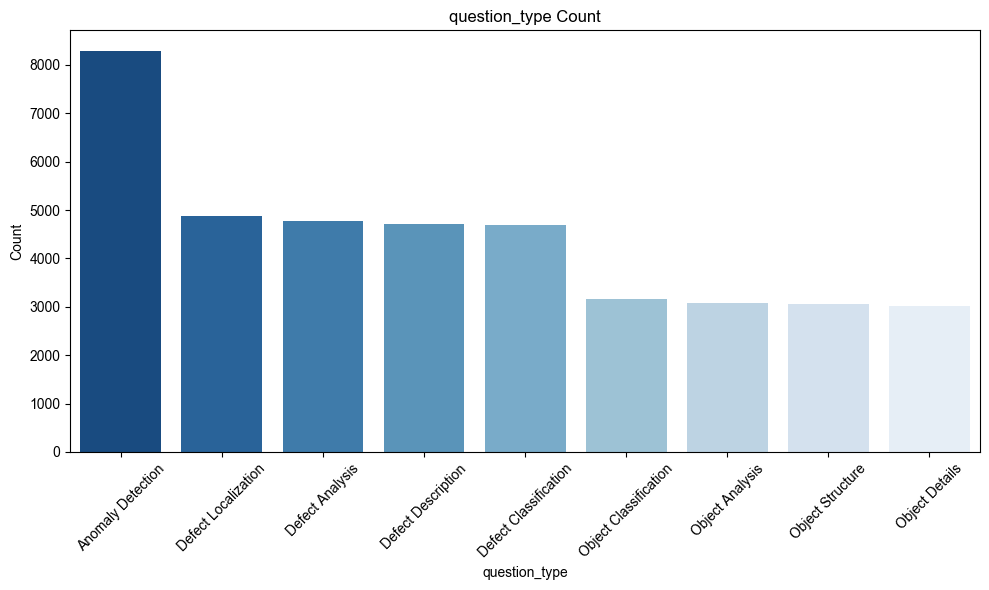

<Axes: title={'center': 'question_type Count'}, xlabel='question_type', ylabel='Count'>

In [ ]:
from src.visual import set_korean_font, count_plot, bar_plot, line_plot, box_plot
set_korean_font(verbose=True)

count_plot(df=df, col='question_type', rotation=45)

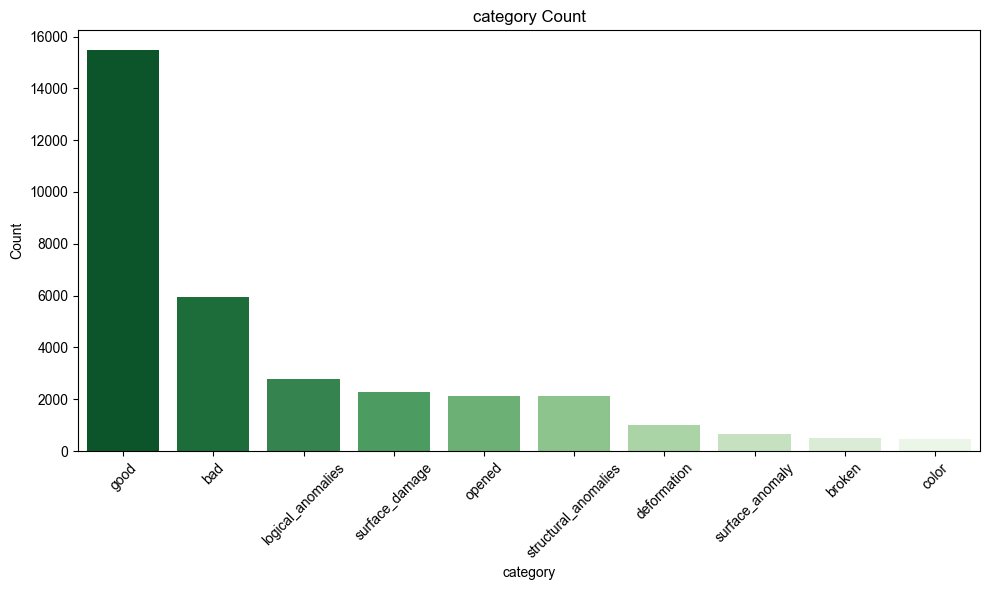

<Axes: title={'center': 'category Count'}, xlabel='category', ylabel='Count'>

In [7]:
count_plot(df=df, col='category', top_n=10, rotation=45, palette='Greens_r')